Hello, hello! Today, we’ll explore how SVD decomposition is useful for image processing.

Below, we’ll follow the video series by Professor Steve Brunton from the University of Washington:
https://www.youtube.com/watch?v=ofWji_wQBEE&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=31
Watch the series here

It’s crucial to have a mathematical background in SVD to truly understand what’s happening here. So, make sure to review your course materials beforehand—or just watch the same video series, it’s actually very good!

A huge thank you to Professor Bernard Manderick from VUB for introducing me to these videos through his seminar!




In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os # a library for interacting with operating system, exp managing files 
import scipy.io #mathematics and linear algebra fonctions

In [40]:
#configure Matplotlib's global plotting settings
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

oky guys, let's upload our data
and understand it first.
the data we are using is the Extended Yale Face Database, consisting of cropped and aligned images of 38 individuals under 9 poses
and 64 lighting conditions6
Each image is 192 pixels tall and 168 pixels wide, presented a column vector of 192x168 = 32 256 elements.
2410 columns in total.




In [41]:
file_path="H:\\Documents\\VUB\\adaptive system siminare\\DATA\\allFaces.mat"
mat_contents = scipy.io.loadmat(file_path)

In [42]:
print(mat_contents)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Sep  4 19:53:55 2014', '__version__': '1.0', '__globals__': [], 'faces': array([[80, 94, 59, ...,  3,  4,  4],
       [81, 87, 67, ...,  4,  4,  3],
       [80, 88, 66, ...,  2,  4,  4],
       ...,
       [14,  7,  6, ...,  0,  1,  1],
       [14,  9,  6, ...,  1,  1,  0],
       [11,  8,  7, ...,  1,  1,  2]], dtype=uint8), 'n': array([[192]], dtype=uint8), 'm': array([[168]], dtype=uint8), 'sub': array([[(array([[39]], dtype=uint8), array([[70, 84, 88, ...,  3,  4,  4],
               [74, 83, 95, ...,  4,  4,  3],
               [69, 82, 97, ...,  2,  4,  4],
               ...,
               [ 1,  2,  3, ...,  0,  1,  1],
               [ 1,  3,  3, ...,  1,  1,  0],
               [ 2,  2,  3, ...,  1,  1,  2]], dtype=uint8), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0

In [43]:
print( mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person'])


mat_contents contains many pieces of information, such as the sub matrix, which holds information about each person and their posters. However, we will focus only on the faces matrix. 
la matrice nfaces contains the number of pictures per person.

In [44]:
 nPictures = mat_contents["nfaces"].sum()

In [45]:
faces=mat_contents["faces"]
print(faces.shape)

(32256, 2410)


In [46]:
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces'])#pour aplattir nfaces.

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_7392\867397994.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(mat_contents['m'])
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_7392\867397994.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(mat_contents['n'])


In [47]:
print(m,n,nfaces,mat_contents['nfaces'] )

168 192 [64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64] [[64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
  64 64 64 64 64 64 64 64 64 64 64 64 64 64]]


Let's visualize the persons whose pictures are in the dataset with this code. The idea is to transform the column of the first picture of each person into an array that represents the picture in (m, n) dimensions, but do this for 36 people.


In [48]:
allPersons = np.zeros((n*6,m*6))
count = 0

for j in range(6):
    for k in range(6):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(faces[:,np.sum(nfaces[:count])],(m,n)).T
        count += 1
#np.sum(nfaces[:count]) gives the index of the first picture of the person number count in the matrix faces . 

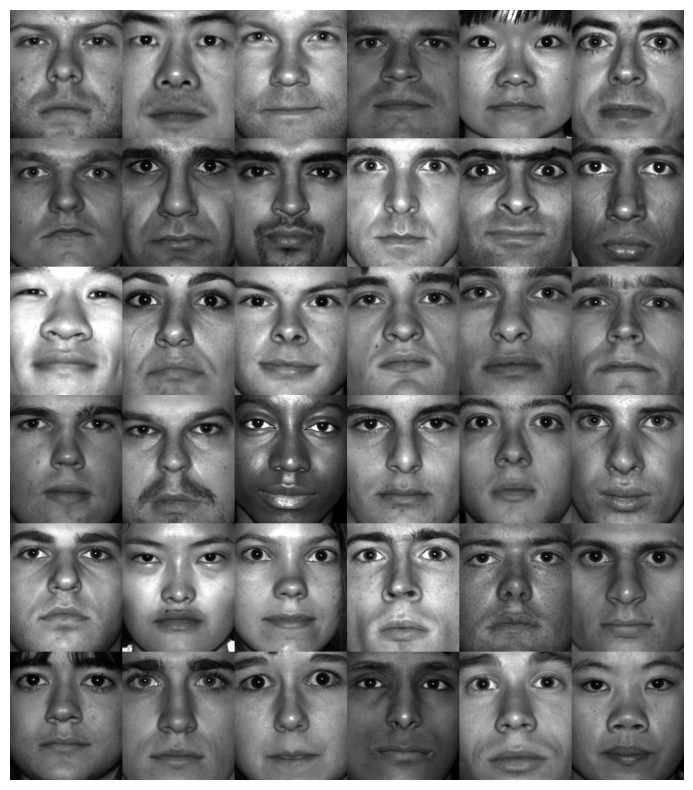

In [49]:
img=plt.imshow(allPersons)
img.set_cmap('gray')
plt.axis('off')
plt.show()

and now let's visualaze the diffrent pictures for the person number X . 

In [50]:
allPictures = np.zeros((n*8, m*8) ) 
count = 0 
X=12
FX=np.sum(nfaces[:X]) # the index of the first picture of the person X .
LX= FX+ nfaces[X]
for i in range ( 0, 8 ) :
    for j in range (0, 8 ):
        allPictures [i * n: (i+1)*n , j*m :(j+1)*m ]= np.reshape(faces[ : , FX+count], (m,n)).T
        count +=1


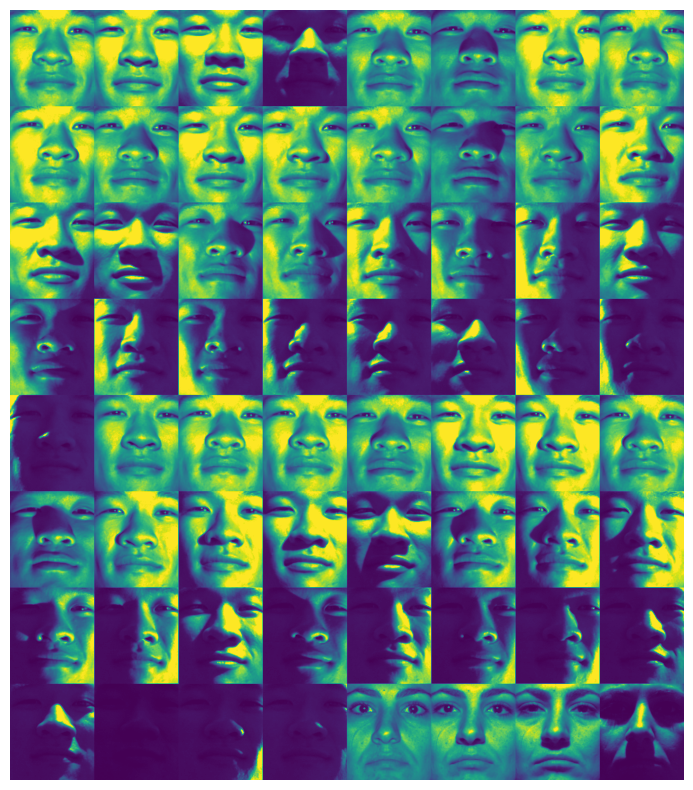

In [51]:
plt.imshow(allPictures)
img.set_cmap('gray')
plt.axis('off')
plt.show()

let's get down to business, and apply the SVD decomposition to our dataSet.
we will use the the 36 first person for trainning our model, and the last 3 persones for testing

In [ ]:
trainingFaces= faces[:,:np.sum(nfaces[:36])]
print(trainingFaces.shape)


(32256, 2282)


In [ ]:
avgFace= np.mean(trainingFaces, axis = 1 )

In [ ]:
print(avgFace.shape)

(32256,)


avg faces is it self a picture, where every pixel is the mean of all the pixeles in traing sets with the same index.
et voilà son plot.

notice that there is another mean , using the axis one 
avgFaces= np.mean(trainingSet, axis = 1 )
print(avgFaces.shape)
(2282,)
and this mean give the mean of the pixels for each picture.


(-0.5, 167.5, 191.5, -0.5)

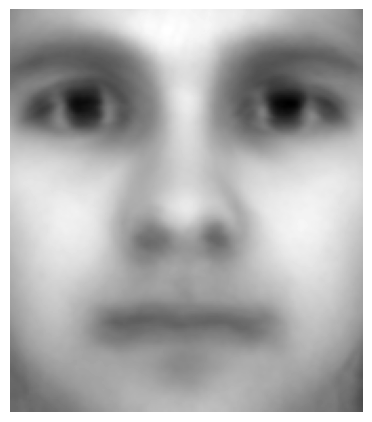

In [33]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
img_avg = ax1.imshow(np.reshape(avgFace,(m,n)).T)
img_avg.set_cmap('gray')
plt.axis('off')

We want to normalize our training set; thus, we have to subtract the mean and divide by the variance.

Normalizing the data is important to prevent bias toward large-valued data because algorithms tend to give more importance to larger values. By normalizing the features, we ensure they are scaled to the same value range, allowing the model to treat them fairly.


In [56]:
X = trainingFaces - np.tile(avgFace,(trainingFaces.shape[1],1)).T
U, S, VT = np.linalg.svd(X,full_matrices=0)


So whatis U, S, VT ? Vt stands for Vᵀ.

*U is an orthonormal matrix where each column represents a principal component (or eigenvector) of X Xᵀ. It forms a new orthonormal basis in which we can efficiently represent all the images. Its shape is (mn, mn).

*S is a diagonal matrix containing the singular values (which are the square roots of the eigenvalues of X Xᵀ or Xᵀ X). These values indicate the importance of each corresponding singular vector.

*V (or more precisely, Vᵀ) is also an orthonormal matrix, encoding the principal components of Xᵀ X. The columns of V (or rows of Vᵀ) correspond to the eigenvectors of Xᵀ X.

*The i-th column of U is related to the singular value σ(i) and the i-th column of V (or Vᵀ) in a way that allows reconstruction of the original data with different levels of approximation.

 We know that U Uᵀ = I, meaning U is an orthonormal matrix.
Here, we will show that the first columns of U contain enough information to visualize our faces efficiently, without needing all the columns.

When we take only the first r columns of U, forming Uᵣ, the property Uᵣ Uᵣᵀ ≠ I holds because Uᵣ is no longer a square orthonormal matrix.

This means we can approximate the original data using only a subset of the principal components, reducing the dimensionality while preserving the most important information. This optimization allows us to compress and reconstruct the images with minimal loss of quality.



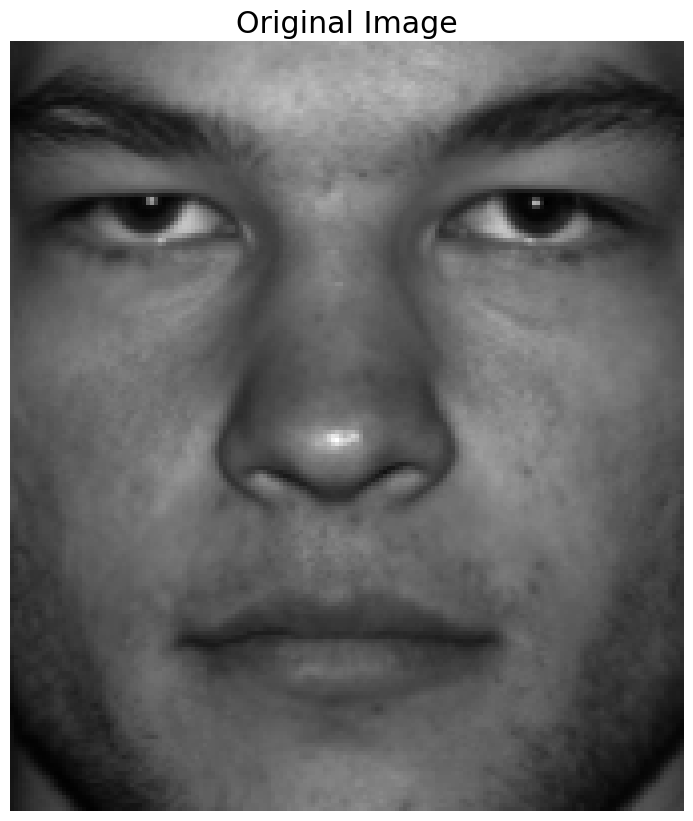

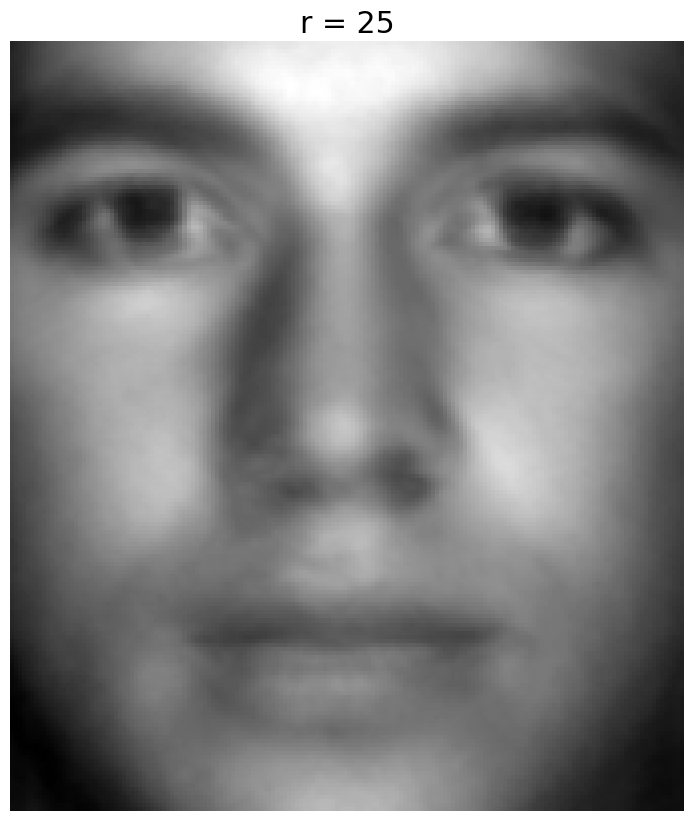

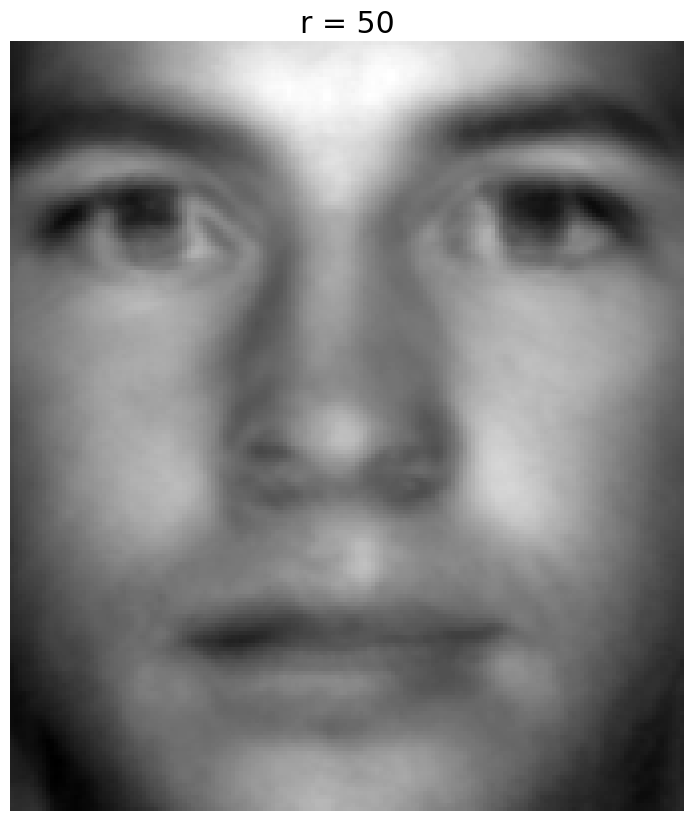

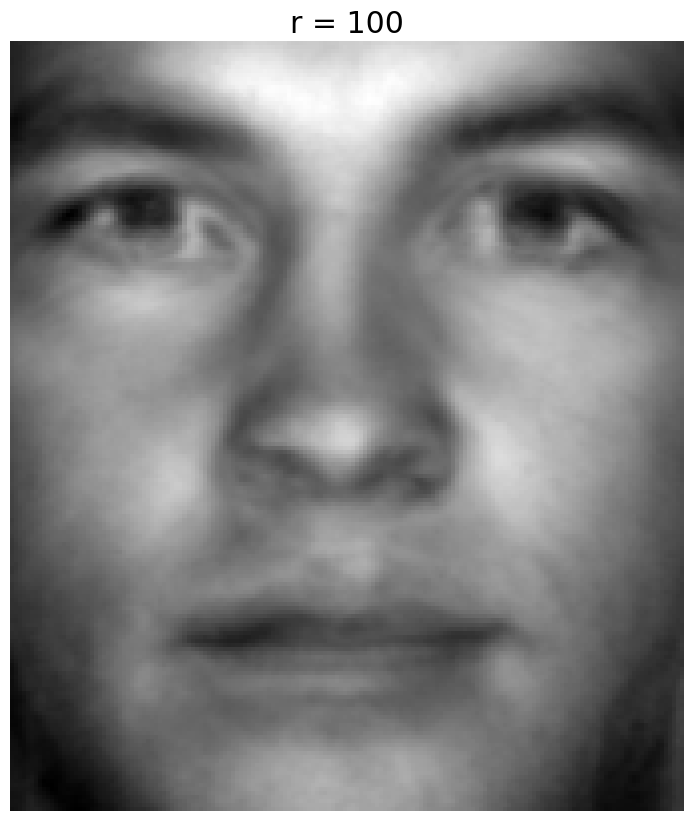

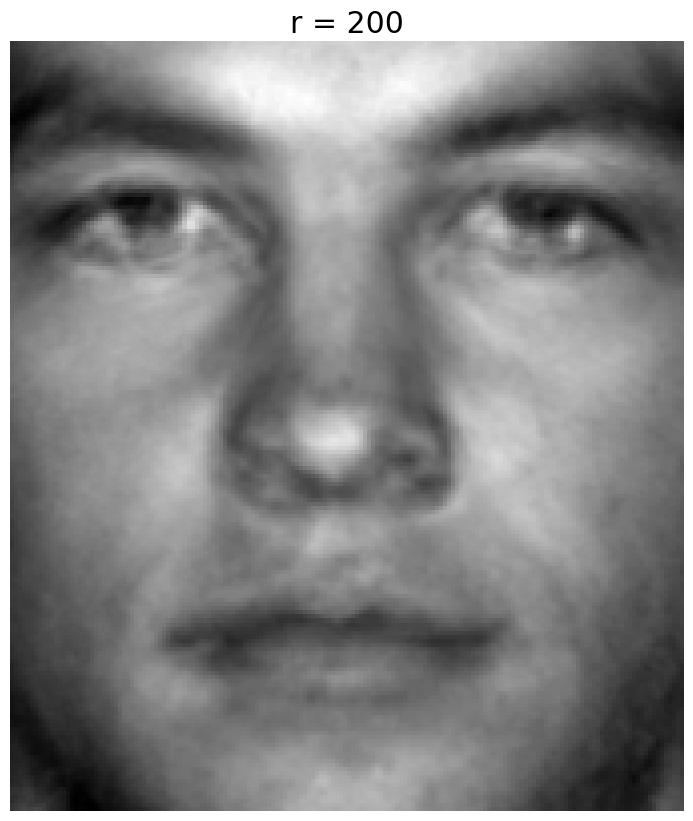

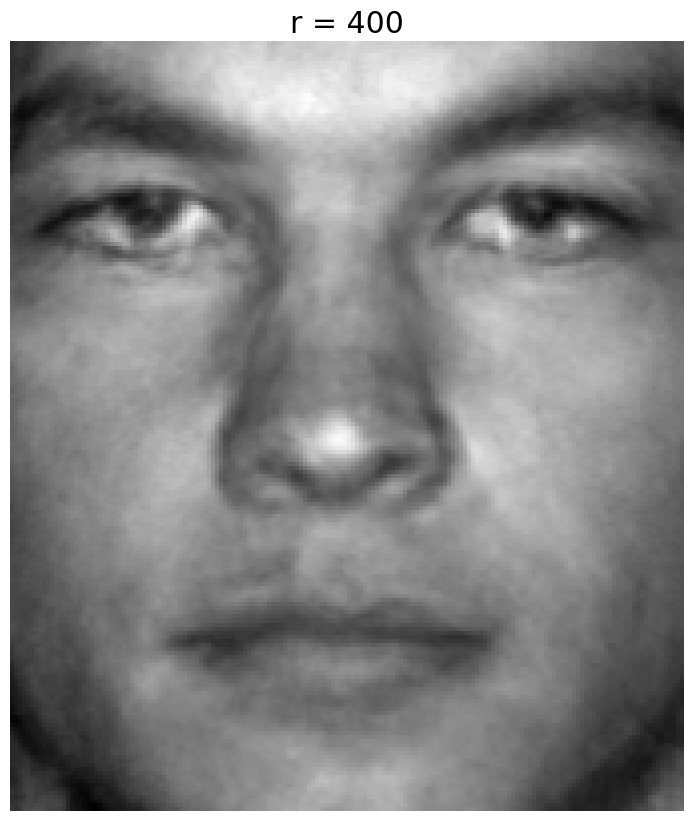

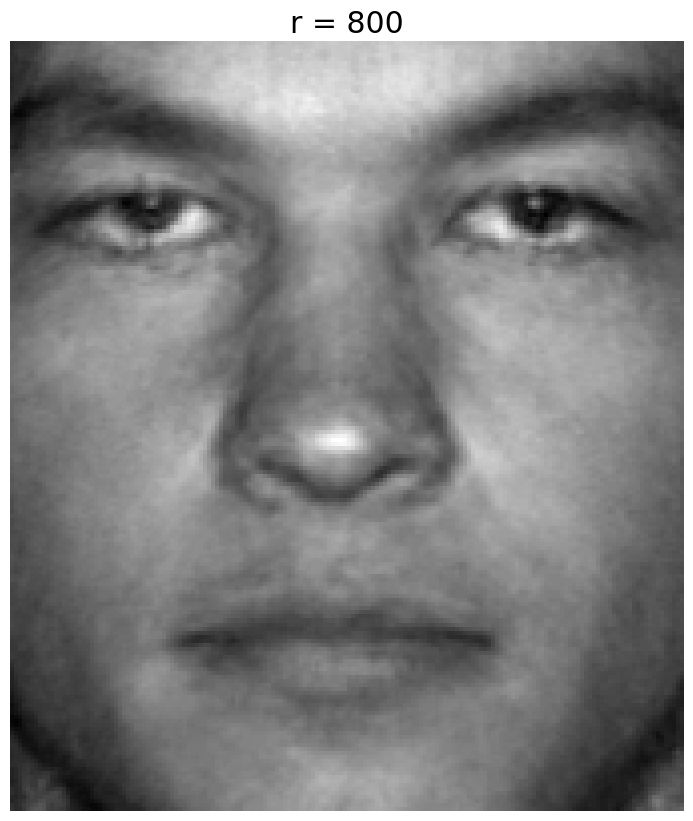

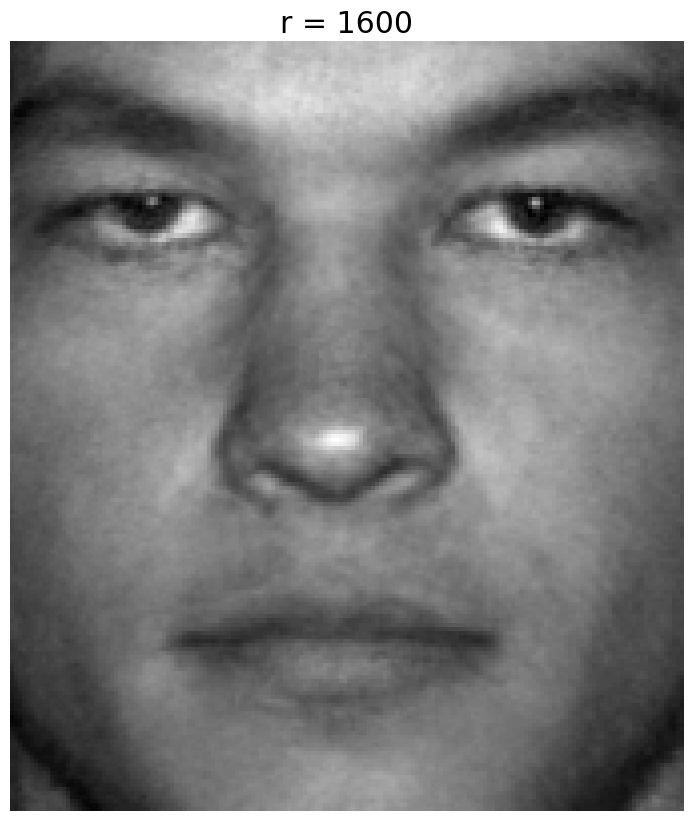

In [57]:
testFace = faces[:,np.sum(nfaces[:36])] # First face of person 37
plt.imshow(np.reshape(testFace,(m,n)).T)
plt.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

testFaceMS = testFace - avgFace
r_list = [25, 50, 100, 200, 400, 800, 1600]

for r in r_list:
    reconFace = avgFace + U[:,:r]  @ U[:,:r].T @ testFaceMS
    img = plt.imshow(np.reshape(reconFace,(m,n)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')
    plt.show()

We notice that the more columns we take, the more our picture resembles the original face. Also, notice that for r = 800, we obtain a satisfactory result, using 800 dimensions instead of 32,256 dimensions.
 r << mn

 Oky so what for ? 

 good question ! we can use this in classifing images for example. 
let's take the arbitrary the two persons : 2,7 , and project them in 5 and 6 PCA modes



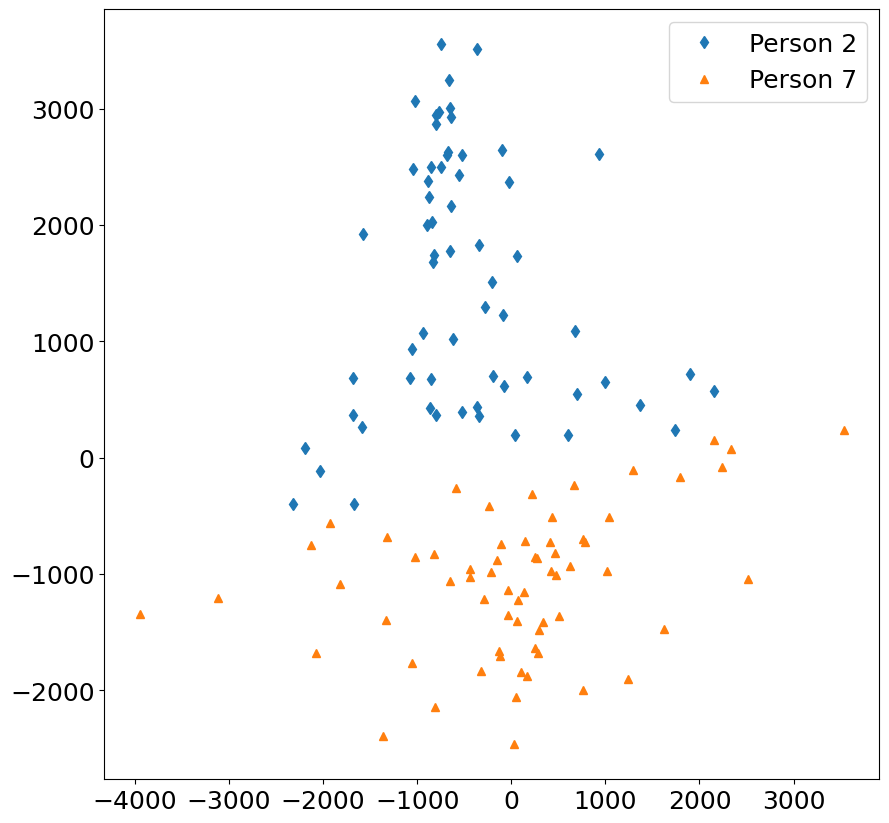

In [60]:
## Project person 2 and 7 onto PC5 and PC6

P1num = 2 # Person number 2
P2num = 7 # Person number 7

P1 = faces[:,np.sum(nfaces[:(P1num-1)]):np.sum(nfaces[:P1num])]
P2 = faces[:,np.sum(nfaces[:(P2num-1)]):np.sum(nfaces[:P2num])]

P1 = P1 - np.tile(avgFace,(P1.shape[1],1)).T
P2 = P2 - np.tile(avgFace,(P2.shape[1],1)).T

PCAmodes = [5, 6] # Project onto PCA modes 5 and 6
PCACoordsP5 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P1
PCACoordsP6 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P2

plt.plot(PCACoordsP1[0,:],PCACoordsP5[1,:],'d',label='Person 2')
plt.plot(PCACoordsP2[0,:],PCACoordsP6[1,:],'^',label='Person 7')

plt.legend()
plt.show()

we notice that they very well clusterd . that means they for real diffrent . 
let's project them in 1 and 2 components also .

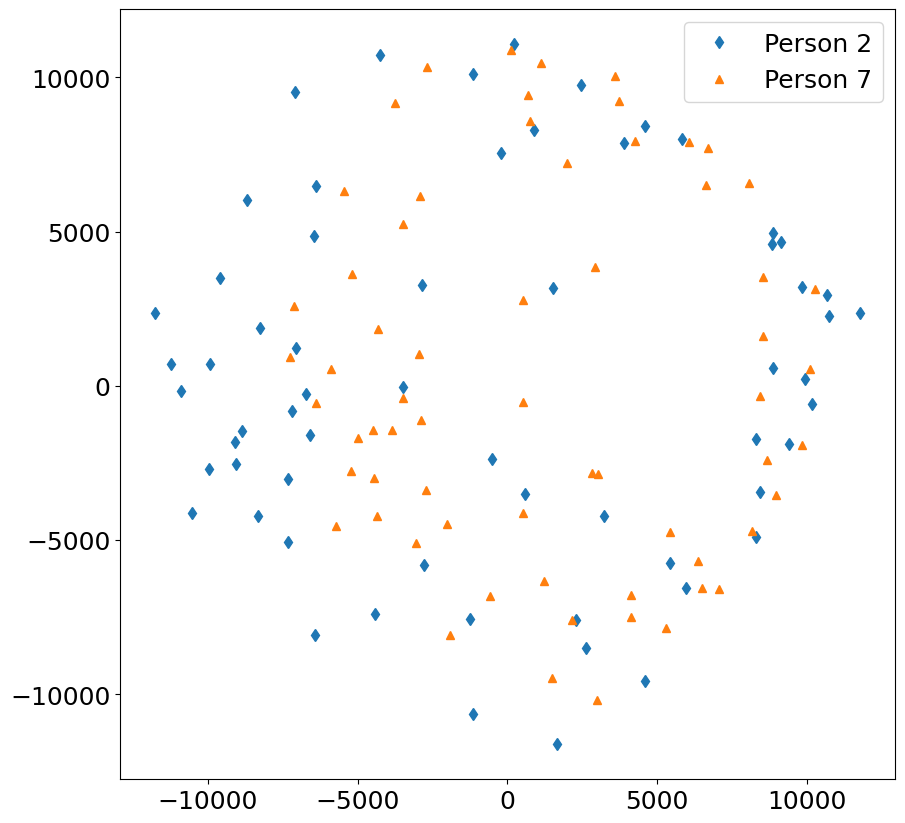

In [61]:
PCAmodes = [1, 2] # Project onto PCA modes 5 and 6
PCACoordsP1 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P1
PCACoordsP2 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P2

plt.plot(PCACoordsP1[0,:],PCACoordsP1[1,:],'d',label='Person 2')
plt.plot(PCACoordsP2[0,:],PCACoordsP2[1,:],'^',label='Person 7')

plt.legend()
plt.show()

Oops, they are not clustered based on these two axes! Are they similar?
Well, no. Usually, the first U vectors encode the information that is common among all the individuals in our dataset. For example, they capture general features like the position of the nose and eyes. On the other hand, the last columns of U contain the variance information, such as the shape of the eyebrows or the curve of the eyes.
So, it's normal to obtain these results.

Voila Voilà , the end thank you for visiting my profile. 
